---
title: Assignment 05
author:
  - name: Zhengyu Zhou
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: today
format:
  docx:
    fontsize: 12pt
date-modified: today
date-format: long
jupyter: python3
execute:
  echo: false
  eval: true
  freeze: auto
---

In [3]:
#1
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/19 02:51:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---


25/11/19 02:51:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

In [4]:
#2 Drop rows with missing values
from pyspark.sql.functions import col

# Columns we care about
continuous_cols = ["MIN_YEARS_EXPERIENCE", "DURATION"]
categorical_col = "EMPLOYMENT_TYPE_NAME"
label_col = "SALARY"

selected_cols = [label_col] + continuous_cols + [categorical_col]

# Keep only relevant columns and drop rows with nulls in them
df_model = (
    df.select(selected_cols)
      .dropna(subset=selected_cols)
)

# Cast numeric columns to double for ML
df_model = (
    df_model
    .withColumn("SALARY", col("SALARY").cast("double"))
    .withColumn("MIN_YEARS_EXPERIENCE", col("MIN_YEARS_EXPERIENCE").cast("double"))
    .withColumn("DURATION", col("DURATION").cast("double"))
)

df_model.show(5, truncate=False)

+--------+--------------------+--------+----------------------+
|SALARY  |MIN_YEARS_EXPERIENCE|DURATION|EMPLOYMENT_TYPE_NAME  |
+--------+--------------------+--------+----------------------+
|192800.0|6.0                 |55.0    |Full-time (> 32 hours)|
|125900.0|12.0                |18.0    |Full-time (> 32 hours)|
|118560.0|5.0                 |20.0    |Full-time (> 32 hours)|
|192800.0|6.0                 |55.0    |Full-time (> 32 hours)|
|116500.0|12.0                |16.0    |Full-time (> 32 hours)|
+--------+--------------------+--------+----------------------+
only showing top 5 rows



These four variables were chosen because the job specifies SALARY as the dependent variable, while MIN_YEARS_EXPERIENCE and DURATION are continuous numerical features that are intuitively related to salary. EMPLOYMENT_TYPE_NAME represents full-time/part-time employment types and has a significant impact on wages. It is also suitable to be demonstrated with StringIndexer and OneHotEncoder.


In [8]:
#2.3 Convert categorical variables
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

data0 = (
    df_model
    .withColumn("SALARY", col("SALARY").cast("double"))
)

# index the categorical variable one-hot
indexer = StringIndexer(
    inputCol="EMPLOYMENT_TYPE_NAME",
    outputCol="EMPLOYMENT_TYPE_IDX",
    handleInvalid="keep"
)

encoder = OneHotEncoder(
    inputCols=["EMPLOYMENT_TYPE_IDX"],
    outputCols=["EMPLOYMENT_TYPE_VEC"]
)

# assemble "basic features" -> features (for GLR/simple linear models)
assembler_base = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "DURATION",
        "EMPLOYMENT_TYPE_VEC"
    ],
    outputCol="features"
)

# One pipeline finishes coding base features
pipe_base = Pipeline(stages=[indexer, encoder, assembler_base])

data_base = pipe_base.fit(data0).transform(data0)

In [ ]:
# new square feature: the square of years of experience
data_poly = data_base.withColumn(
    "MIN_YEARS_EXPERIENCE_SQ",
    pow(col("MIN_YEARS_EXPERIENCE"), 2)
)

# assemble polynomial features -> features_poly
assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE",
        "MIN_YEARS_EXPERIENCE_SQ", 
        "DURATION",
        "EMPLOYMENT_TYPE_VEC"
    ],
    outputCol="features_poly"
)

data_poly = assembler_poly.transform(data_poly)

# keep the columns you will use later
final_df = data_poly.select("SALARY", "features", "features_poly")
final_df.show(5, truncate=False)

+--------+-----------------------+-----------------------------+
|SALARY  |features               |features_poly                |
+--------+-----------------------+-----------------------------+
|192800.0|[6.0,55.0,1.0,0.0,0.0] |[6.0,36.0,55.0,1.0,0.0,0.0]  |
|125900.0|[12.0,18.0,1.0,0.0,0.0]|[12.0,144.0,18.0,1.0,0.0,0.0]|
|118560.0|[5.0,20.0,1.0,0.0,0.0] |[5.0,25.0,20.0,1.0,0.0,0.0]  |
|192800.0|[6.0,55.0,1.0,0.0,0.0] |[6.0,36.0,55.0,1.0,0.0,0.0]  |
|116500.0|[12.0,16.0,1.0,0.0,0.0]|[12.0,144.0,16.0,1.0,0.0,0.0]|
+--------+-----------------------+-----------------------------+
only showing top 5 rows



This table indicates that we have constructed two feature vectors for each record: features are the original linear features (years of experience, duration of days, and type of employment one-hot), and features_poly adds the square term of years of experience on this basis. In this way, we can use the same data to train a common linear model (using features) and a polynomial regression model (using features_poly) respectively to compare the effects of predicting salaries.

In [13]:
#3 Split the data
# Final DataFrame with only SALARY and features
data = final_df.select(
    col("SALARY").cast("double").alias("SALARY"),
    "features",
    "features_poly"
)

df_train, df_test = data.randomSplit([0.8, 0.2], seed=42)

#Dimension of training and test data
print (f"Dimensions of full data: {final_df.count()} rows, {len(final_df. columns)} columns") 
print (f"Dimensions of training data: {df_train.count()} rows, {len(df_train. columns)} columns") 
print (f"Dimensions of test data: {df_test.count()} rows, {len(df_test. columns)} columns")

Dimensions of full data: 14416 rows, 3 columns


Dimensions of training data: 11604 rows, 3 columns


Dimensions of test data: 2812 rows, 3 columns


In [14]:
df_train.show(5, truncate=False)

+-------+----------------------+--------------------------+
|SALARY |features              |features_poly             |
+-------+----------------------+--------------------------+
|15860.0|(5,[1,3],[37.0,1.0])  |(6,[2,4],[37.0,1.0])      |
|22440.0|[3.0,53.0,1.0,0.0,0.0]|[3.0,9.0,53.0,1.0,0.0,0.0]|
|23179.0|[1.0,26.0,1.0,0.0,0.0]|[1.0,1.0,26.0,1.0,0.0,0.0]|
|23585.0|(5,[1,3],[13.0,1.0])  |(6,[2,4],[13.0,1.0])      |
|24960.0|[1.0,31.0,1.0,0.0,0.0]|[1.0,1.0,31.0,1.0,0.0,0.0]|
+-------+----------------------+--------------------------+
only showing top 5 rows



In [16]:
#4 Train a Linear Regression model
from pyspark.ml. regression import GeneralizedLinearRegression

feature_names = [
    "MIN_YEARS_EXPERIENCE",
    "DURATION",
    "EMPLOYMENT_TYPE_VEC_0",
    "EMPLOYMENT_TYPE_VEC_1",
    "EMPLOYMENT_TYPE_VEC_2",
]
 
glr = GeneralizedLinearRegression(
    family="gaussian",
    link="identity",
    featuresCol="features",
    labelCol="SALARY",
    predictionCol="prediction",
    maxIter=50,
    regParam=0.3      
)

glr_model = glr.fit(df_train)

# Get model summary
glr_summary = glr_model.summary


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator   
from pyspark.sql.functions import col
pred_test = glr_model.transform(df_test)

eval_r2   = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
eval_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
eval_mae  = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2_test   = eval_r2.evaluate(pred_test)
rmse_test = eval_rmse.evaluate(pred_test)
mae_test  = eval_mae.evaluate(pred_test)

print("\n--- Model & Test Metrics ---")
print(f"Intercept: {glr_model.intercept}")
print(f"Coefficients: {list(glr_model.coefficients)}")
print(f"R²  (test): {r2_test:.4f}")
print(f"RMSE(test): {rmse_test:.2f}")
print(f"MAE (test): {mae_test:.2f}")


--- Model & Test Metrics ---
Intercept: 82266.51254464507
Coefficients: [np.float64(6797.259817002418), np.float64(-16.48736631804831), np.float64(865.3463264589267), np.float64(-1109.9561982133198), np.float64(-337.28064641290854)]
R²  (test): 0.2754
RMSE(test): 35405.94
MAE (test): 27327.93


The intercept value of this model is approximately $82,267, which represents the base salary when all features are at the reference level. The coefficients indicate that the more work experience required, the higher the predicted salary, while the influence of the posting duration and job type is relatively small. The R² value of this model is approximately 0.28, the test root mean square error is approximately $35,000 (the average absolute error is approximately $27,000), and it can capture some changes in salary, but there are still large errors in the prediction for individual positions.

In [22]:
features_all = ["Intercept"] + feature_names         # 共 1 + 5 = 6 个
coefs_all    = [glr_model.intercept] + list(glr_model.coefficients)

# Try to get SE/t/p from the summary. If you can't get it, use None

se_all    = list(glr_summary.coefficientStandardErrors)
tvals_all = list(glr_summary.tValues)
pvals_all = list(glr_summary.pValues)

print("\n---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(features_all))
print("Length of coefs   :", len(coefs_all))
print("Length of se      :", len(se_all))
print("Length of tvals   :", len(tvals_all))
print("Length of pvals   :", len(pvals_all))



---This is Diagnostic check, No need to print it in the final doc---
Length of features: 6
Length of coefs   : 6
Length of se      : 6
Length of tvals   : 6
Length of pvals   : 6


In [23]:
import pandas as pd
from IPython.display import HTML
import os

# Create a coefficient table
coef_table = pd.DataFrame({
    "Feature": features_all,
    "Estimate": [
        f"{v:.4f}" if v is not None else None
        for v in coefs_all
    ],
    "Std Error": [
        f"{v:.4f}" if v is not None else None
        for v in se_all
    ],
    "t-stat": [
        f"{v:.4f}" if v is not None else None
        for v in tvals_all
    ],
    "P-Value": [
        f"{v:.4f}" if v is not None else None
        for v in pvals_all
    ],
})

#Save for report
coef_table.to_csv("_output/coefficient_table.csv", index=False)

The intercept value has a high degree of significance, indicating that the estimated value of the base salary is approximately $82,000. However, the coefficient for the minimum working years - although positive - has a large p-value (approximately 0.48), so its impact is not statistically significantly different from zero. The coefficients for the duration and the three dummy variables for the types of employment both have extremely large standard errors and p-values close to 1, which means that this model cannot provide reliable evidence that these characteristics have a significant impact on wages.

In [27]:
#5 
# obtain the prediction from Spark
from pyspark.sql.functions import col

pred_test = glr_model.transform(df_test)
pred_test = pred_test.withColumn("residual", col("SALARY") - col("prediction"))

pdf = pred_test.select("SALARY", "prediction", "residual").toPandas()


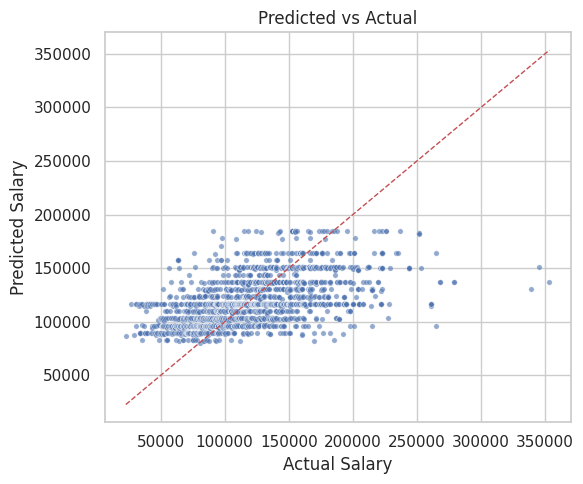

In [ ]:
#Predicted vs Actual Plot
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pdf, x="SALARY", y="prediction", s=15, alpha=0.6)

# reference line
min_val = min(pdf["SALARY"].min(), pdf["prediction"].min())
max_val = max(pdf["SALARY"].max(), pdf["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.title("Predicted vs Actual")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.tight_layout()
plt.savefig("_output/predicted_vs_actual.png", dpi=300)
plt.show()


The points on the graph are roughly distributed along the diagonal, indicating that there is a certain positive correlation between the model's prediction and the actual wages.
However, most of the points deviate from the red line, especially in the high-wage areas where they are significantly lower. This suggests that the model systematically underestimates high-paying positions, and the prediction error for individual samples is relatively large.

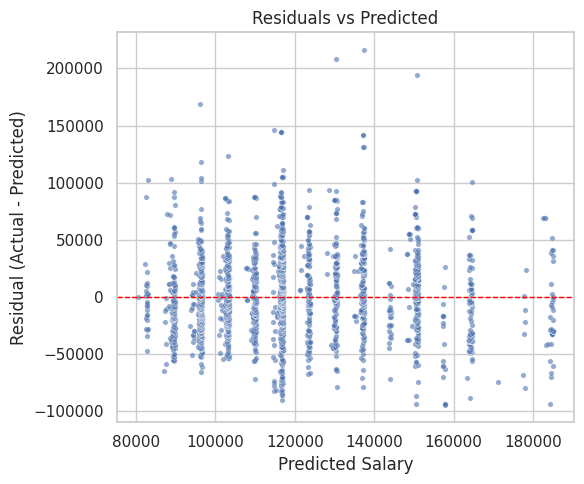

In [29]:
# Residuals vs Predicted Plot
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=pdf, x="prediction", y="residual", s=15, alpha=0.6, ax=ax)

ax.axhline(0, color="red", linestyle="--", linewidth=1)

ax.set_title("Residuals vs Predicted")
ax.set_xlabel("Predicted Salary")
ax.set_ylabel("Residual (Actual - Predicted)")

fig.tight_layout()
fig.savefig("_output/residuals_vs_predicted.png", dpi=300, bbox_inches="tight")
plt.show()


The residuals roughly spread out around the red 0 line, indicating that the model overestimates and underestimates at different predicted salary levels. Overall, the variance varies slightly with the predicted value, and the residual is quite large, indicating that the error is not completely uniform and the model's fitting ability is limited.

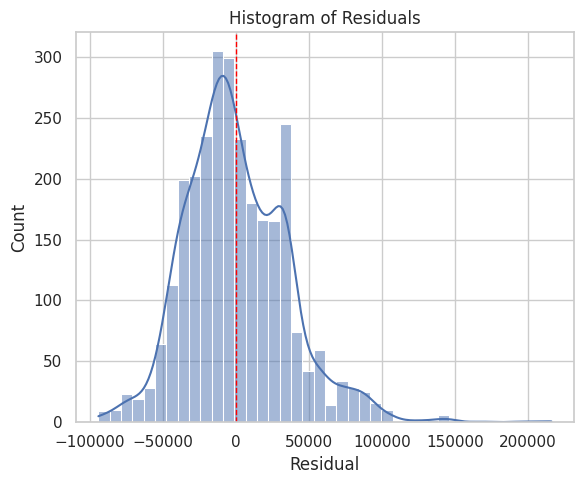

In [30]:
# Histogram of Residuals
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(pdf["residual"], bins=40, kde=True, ax=ax)

ax.axvline(0, color="red", linestyle="--", linewidth=1)

ax.set_title("Histogram of Residuals")
ax.set_xlabel("Residual")
ax.set_ylabel("Count")

fig.tight_layout()
fig.savefig("_output/residuals_hist.png", dpi=300, bbox_inches="tight")
plt.show()

This histogram shows that most of the residuals are concentrated around 0, indicating that the model typically only produces moderate errors when predicting salaries. The long tail on the right and the skewed distribution to the right suggest that the model has many cases where it significantly underestimates the actual salary, and the error distribution does not fully conform to the normal assumption.

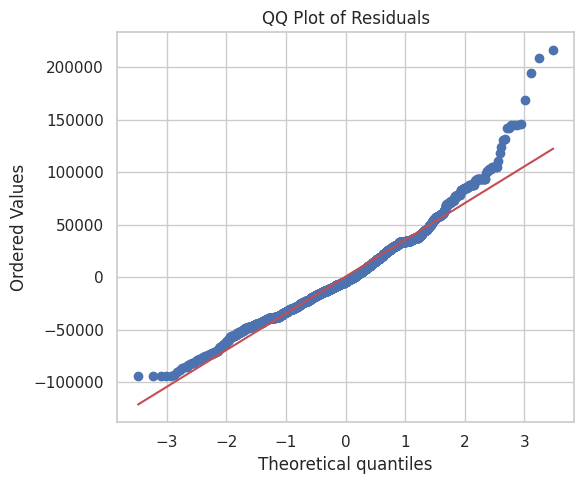

In [31]:
# QQ Plot of Residuals
import scipy.stats as stats

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(6, 5))
stats.probplot(pdf["residual"], dist="norm", plot=ax)

ax.set_title("QQ Plot of Residuals")

fig.tight_layout()
fig.savefig("_output/residuals_qqplot.png", dpi=300, bbox_inches="tight")
plt.show()

The QQ plot shows that the residuals in the middle range lie close to the reference line, suggesting that most salary prediction errors are approximately normally distributed. However, the clear deviations in the upper and lower tails—especially the heavy upper tail—indicate that errors for extremely high (and very low) salaries depart from normality, so predictions for high-paying positions are less reliable.


--- Information Criteria ---
AIC: 276610.4105
BIC: 243721.8397


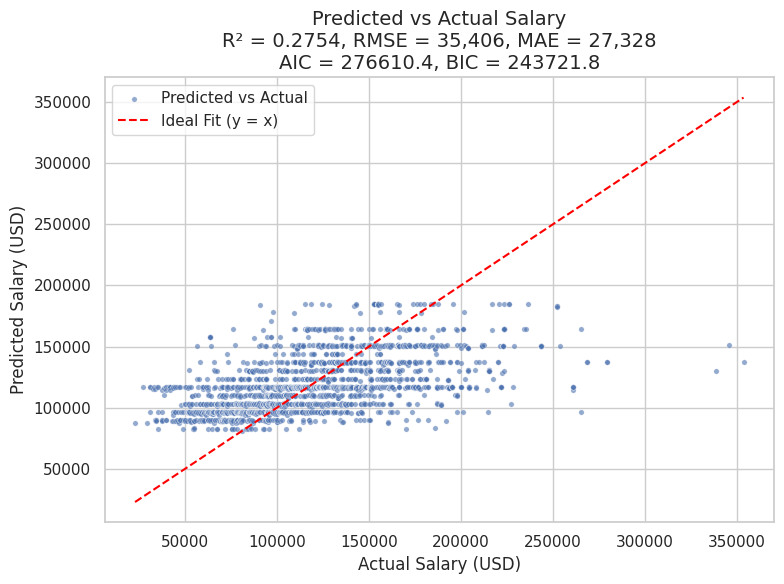

In [35]:
# 6 Evaluation & 6.1 Model Evaluation Plot

import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

sns.set(style="whitegrid")

# take AIC from GLR summary and calculate BIC yourself
glr_summary = glr_model.summary

aic = glr_summary.aic
n   = glr_summary.numInstances                  # Sample size
k   = len(glr_model.coefficients) + 1           # Number of parameters = Intercept coefficient
rss = glr_summary.deviance                      # Residual Deviance under the Gauss family ≈ RSS

bic = n * math.log(rss / n) + k * math.log(n)

print("\n--- Information Criteria ---")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# score on the test set and convert to pandas
pred_test = glr_model.transform(df_test)

evaluator_r2   = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2_test   = evaluator_r2.evaluate(pred_test)
rmse_test = evaluator_rmse.evaluate(pred_test)
mae_test  = evaluator_mae.evaluate(pred_test)

pdf_eval = pred_test.select("SALARY", "prediction").toPandas()

# Predicted vs Actual Salary graph
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=pdf_eval,
    x="SALARY",
    y="prediction",
    s=15,
    alpha=0.6,
    ax=ax,
    label="Predicted vs Actual"
)

# ideal fitting line
min_val = min(pdf_eval["SALARY"].min(), pdf_eval["prediction"].min())
max_val = max(pdf_eval["SALARY"].max(), pdf_eval["prediction"].max())
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Ideal Fit (y = x)"
)

# Include R² / RMSE/AIC/BIC in the title
ax.set_title(
    f"Predicted vs Actual Salary\n"
    f"R² = {r2_test:.4f}, RMSE = {rmse_test:,.0f}, MAE = {mae_test:,.0f}\n"
    f"AIC = {aic:.1f}, BIC = {bic:.1f}",
    fontsize=14
)
ax.set_xlabel("Actual Salary (USD)")
ax.set_ylabel("Predicted Salary (USD)")
ax.legend(loc="upper left")

plt.tight_layout()

fig.savefig("_output/model_evaluation_pred_vs_actual.png", dpi=300, bbox_inches="tight")

plt.show()

In this graph, the point cloud is generally distributed along the diagonal in a positive direction. However, a large number of high-paying job points are below the red line, indicating that the model significantly underestimates salaries in the high-wage range. The prediction error for individual positions is still relatively large. R² ≈ 0.28, RMSE ≈ 35k, and MAE ≈ 27k suggest that the model can only explain a small portion of the wage fluctuations, and the large AIC/BIC also indicates that the current linear model using these three features has limited fitting degree and there is room for improvement.